In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataseto import DeepfakeDataset, collectPhilos
from modelo import VeriVoice
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = os.path.join(os.getcwd(), "DF-Audio-Dataset", "DeepFake")
batch_size = 16
lr = 1e-4
epochs = 20

In [3]:
for filo in os.listdir(base_path):
    print(filo)

RealAudios
FakeAudios


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA available: True
Number of GPUs: 1


In [5]:
files, labels = collectPhilos(base_path)
if not files:
    raise RuntimeError(f"No audio files found in '{base_path}'")
combined = list(zip(files, labels)); random.shuffle(combined)
files, labels = zip(*combined)
split = int(0.8 * len(files))
train_files, test_files = files[:split], files[split:]
train_labels, test_labels = labels[:split], labels[split:]
train_ds = DeepfakeDataset(train_files, train_labels)
test_ds  = DeepfakeDataset(test_files, test_labels)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
model = VeriVoice().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [7]:
trainoVect = []
testoVect=[]
def eval_loader(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [8]:
for epoch in range(1, epochs + 1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    tr_acc = eval_loader(train_loader)
    te_acc = eval_loader(test_loader)
    trainoVect.append(tr_acc)
    testoVect.append(te_acc)
    print(f"Epoch {epoch:02d}: Train Acc {tr_acc*100:.2f}%, Test Acc {te_acc*100:.2f}%")

Epoch 01: Train Acc 96.83%, Test Acc 96.79%
Epoch 02: Train Acc 98.94%, Test Acc 99.16%
Epoch 03: Train Acc 99.32%, Test Acc 99.32%
Epoch 04: Train Acc 99.83%, Test Acc 99.49%
Epoch 05: Train Acc 98.99%, Test Acc 99.32%
Epoch 06: Train Acc 100.00%, Test Acc 99.49%
Epoch 07: Train Acc 100.00%, Test Acc 99.83%
Epoch 08: Train Acc 100.00%, Test Acc 99.66%
Epoch 09: Train Acc 100.00%, Test Acc 99.66%
Epoch 10: Train Acc 100.00%, Test Acc 99.66%
Epoch 11: Train Acc 100.00%, Test Acc 99.66%
Epoch 12: Train Acc 100.00%, Test Acc 99.66%
Epoch 13: Train Acc 100.00%, Test Acc 99.66%
Epoch 14: Train Acc 100.00%, Test Acc 99.49%
Epoch 15: Train Acc 100.00%, Test Acc 99.49%
Epoch 16: Train Acc 100.00%, Test Acc 99.49%
Epoch 17: Train Acc 100.00%, Test Acc 99.49%
Epoch 18: Train Acc 100.00%, Test Acc 99.49%
Epoch 19: Train Acc 100.00%, Test Acc 99.66%
Epoch 20: Train Acc 100.00%, Test Acc 99.66%


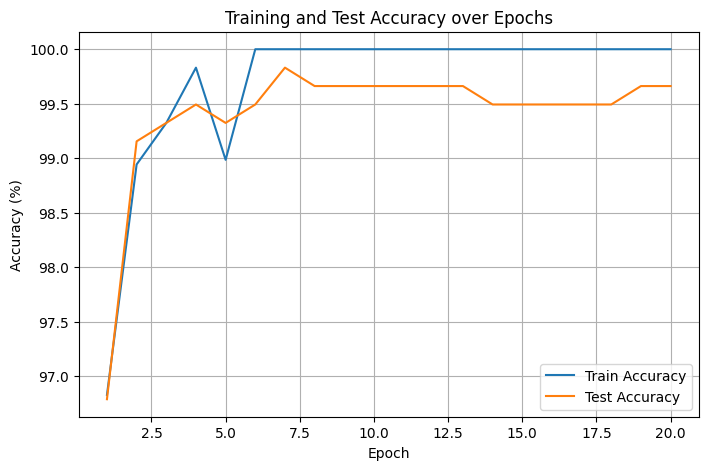

In [9]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), [a*100 for a in trainoVect], label='Train Accuracy')
plt.plot(range(1, epochs+1), [a*100 for a in testoVect], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

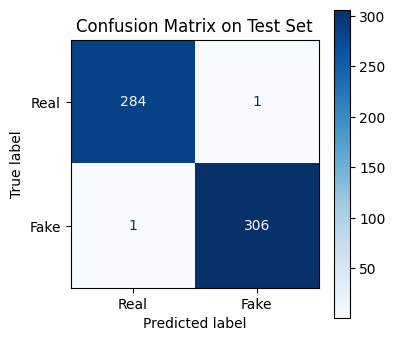

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(y.tolist())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake'])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [13]:
import torchaudio
from torchaudio.transforms import Resample, MelSpectrogram, AmplitudeToDB
audioPhilo = 'DF-Audio-Dataset/DeepFake/FakeAudios/speaker1_recordings/speaker1_output27.wav'

waveform, sr = torchaudio.load(audioPhilo)
if sr != 16000:
    waveform = Resample(sr, 16000)(waveform)
waveform = waveform.mean(dim=0, keepdim=True)
mel = MelSpectrogram(sample_rate=16000, n_mels=80)(waveform)
mel_db = AmplitudeToDB()(mel)
mel_norm = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

T = mel_norm.size(2)
if T < 1000:
    mel_norm = torch.nn.functional.pad(mel_norm, (0, 1000 - T))
else:
    mel_norm = mel_norm[:, :, :1000]

model.eval()
with torch.no_grad():
    xd = mel_norm.to(device)
    logito = model(xd)
    predo = logito.argmax(dim=1).item()
    labelo = 'Fake' if predo == 1 else 'Real'
    print(f"File: {os.path.basename(audioPhilo)} prediction: {labelo}")

File: speaker1_output27.wav prediction: Fake


In [14]:
torch.save(model.state_dict(), 'modelo.pth')
print("Model saved!")

Model saved!
